<a href="https://colab.research.google.com/github/Jingut/GoingDeeper/blob/main/GD_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#프로젝트: CAM을 만들고 평가해 보자
라이브러리 버전 확인하기

사용할 라이브러리 버전을 확인해봐요.

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import plot_model
# Helper libraries
import os
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import numpy as np
import copy
import cv2
import PIL
from PIL import Image
print(PIL.__version__)

8.3.2


In [2]:
!pip install --upgrade pillow==8.3.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#데이터셋 다운로드


In [3]:
# 최초 수행시에는 다운로드가 진행됩니다. 오래 걸릴 수 있으니 유의해 주세요.  
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

#데이터셋 확인


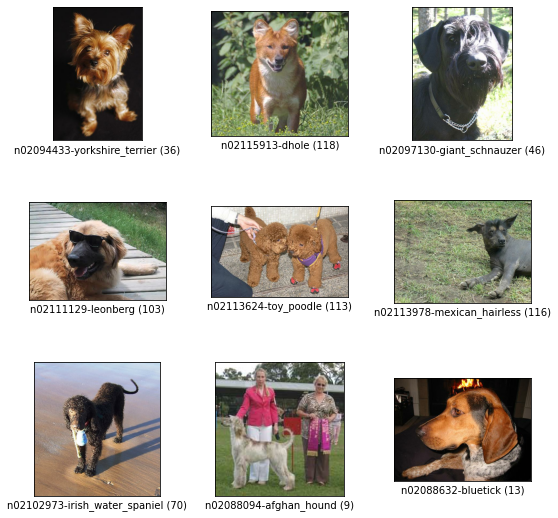

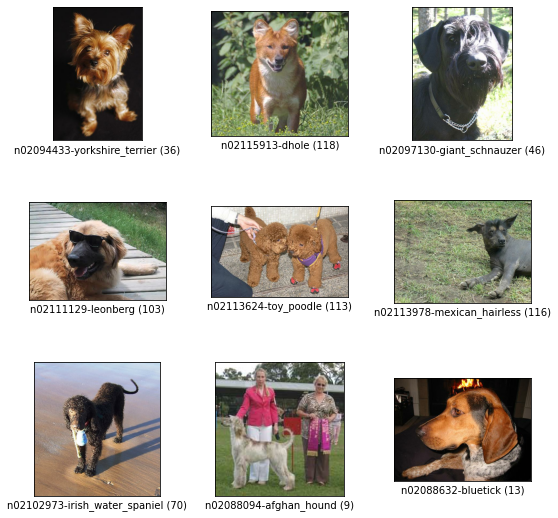

In [4]:
tfds.show_examples(ds_train, ds_info)

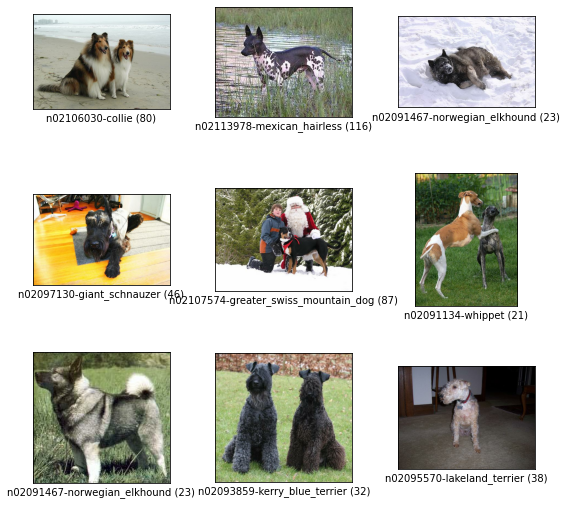

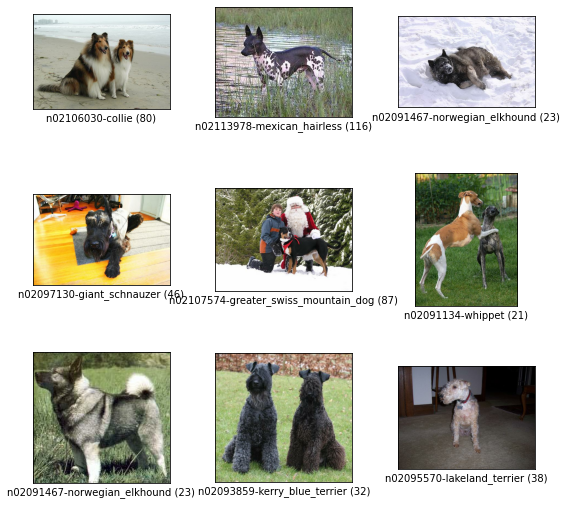

In [5]:
tfds.show_examples(ds_test, ds_info)

In [6]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

데이터셋 개수 확인


In [7]:
print(tf.data.experimental.cardinality(ds_train))  # tf.Tensor(12000, shape=(), dtype=int64)
print(tf.data.experimental.cardinality(ds_test))  # tf.Tensor(8580, shape=(), dtype=int64)

tf.Tensor(12000, shape=(), dtype=int64)
tf.Tensor(8580, shape=(), dtype=int64)


클래스 갯수 확인


In [8]:
ds_info.features["label"].num_classes

120

#이미지 전처리


In [9]:
def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [10]:
# 데이터셋에 전처리와 배치처리를 적용합니다. 
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_test_norm = apply_normalize_on_dataset(ds_test)

# 구성된 배치의 모양을 확인해 봅니다. 
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


##CAM 구현하기
1. 이번 노드에 나왔던 CAM을 직접 구현해 봅시다. 예제 코드를 최대한 보지 말고, 설명과 이론을 보고 구현해 보세요.


In [11]:
def create_cam_model():
    base_model = keras.applications.resnet50.ResNet50(
    include_top = False, # Imagenet 분류기  fully connected layer 사용안함
    weights = 'imagenet',
    input_shape = (224,224,3),
    pooling = 'avg', # GAP 이기 때문에
    )
    x = base_model.output
    preds = keras.layers.Dense(120, activation = 'softmax')(x)
    cam_model = keras.Model(inputs=base_model.input, outputs=preds)
    return cam_model

In [12]:
cam_model = create_cam_model()

In [13]:
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [14]:
epochs = 10
batch_size = 16

In [15]:
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

In [16]:
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=epochs,
    validation_data=ds_test_norm,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
750/750 [==============================] - 175s 220ms/step - loss: 2.1790 - accuracy: 0.4476 - val_loss: 3.2633 - val_accuracy: 0.2268
Epoch 2/10
750/750 [==============================] - 164s 218ms/step - loss: 0.6694 - accuracy: 0.8176 - val_loss: 1.1456 - val_accuracy: 0.6631
Epoch 3/10
750/750 [==============================] - 163s 218ms/step - loss: 0.1773 - accuracy: 0.9669 - val_loss: 0.9327 - val_accuracy: 0.7254
Epoch 4/10
750/750 [==============================] - 163s 218ms/step - loss: 0.0471 - accuracy: 0.9973 - val_loss: 0.9160 - val_accuracy: 0.7320
Epoch 5/10
750/750 [==============================] - 163s 218ms/step - loss: 0.0201 - accuracy: 0.9996 - val_loss: 0.9120 - val_accuracy: 0.7395
Epoch 6/10
750/750 [==============================] - 163s 218ms/step - loss: 0.0129 - accuracy: 0.9999 - val_loss: 0.9279 - val_accuracy: 0.7444
Epoch 7/10
750/750 [==============================] - 163s 218ms/step - loss: 0.0095 - accuracy: 1.0000 - val_loss: 0.9366 -

가중치 저장


In [17]:
import os

cam_model_path = '/content/drive/MyDrive/aiffel/class_activation_map/cam_model1.h5'
cam_model.save(cam_model_path)
print("저장 완료!")

저장 완료!


#시각화

In [18]:
def draw_history(history):
    plt.subplots(figsize=(12,4))

    # CAM Model Loss, Validation Loss 시각화
    plt.subplot(121)
    plt.plot(history.history['loss'], 'r')
    plt.plot(history.history['val_loss'], 'b')
    plt.title('CAM Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['loss', 'val_loss'], loc='upper left')

    # CAM Model Accuracy, Validation Accuracy 시각화
    plt.subplot(122)
    plt.plot(history.history['accuracy'], 'r')
    plt.plot(history.history['val_accuracy'], 'b')
    plt.title('CAM Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['accuracy', 'val_accuracy'], loc='upper left')

    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/aiffel/class_activation_map/result/CAM_Model_Result.png')  # 저장
    plt.show()

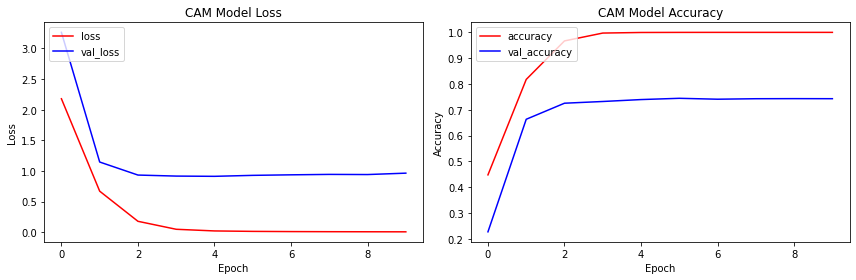

In [19]:
draw_history(history_cam_model)

학습완료한 CAM모델 불러오기


In [20]:
cam_model = tf.keras.models.load_model(cam_model_path)
print("OK")

OK


In [21]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    # model.layers[-3].output에서는 우리가 필요로 하는 GAP 이전 Convolution layer의 output을 얻을 수 있습니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    conv_outputs = conv_outputs[0, :, :, :]
    
    # 모델의 weight activation은 마지막 layer에 있습니다.
    class_weights = model.layers[-1].get_weights()[0] 
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # conv_outputs의 i번째 채널과 i번째 weight를 곱해서 누적하면 활성화된 정도가 나타날 겁니다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    return cam_image

In [22]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

67


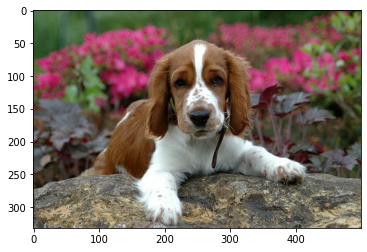

In [23]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

2. 만든 함수로 CAM 이미지를 생성합시다.


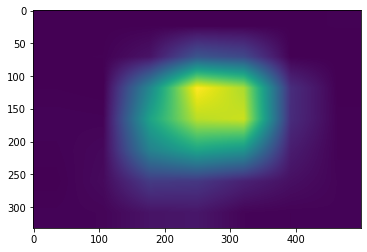

In [24]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

3. 원본 이미지와 CAM 이미지를 입력으로 받고 두 개의 이미지의 투명도를 조정, 하나의 이미지에서 원본과 CAM을 겹쳐 보여주는 visualize_cam_on_image() 함수를 만들어보세요.

[webnautes님의 OpenCV Python 강좌 - 두 개의 이미지 더하기, 블렌딩](https://webnautes.tistory.com/1245)

In [25]:
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

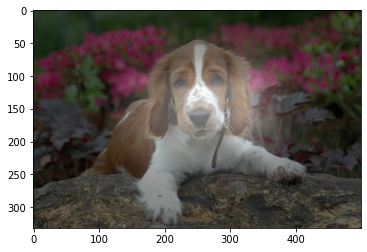

In [26]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

In [27]:
def visualize_cam_on_image(item, cam_image, alpha=0.5):

  origin_image = item['image'].astype(np.uint8)
  cam_image_3channel = np.stack(np.maximum([cam_image*255]*3,0), axis=-1).astype(np.uint8) 
  blended_image = cv2.addWeighted(cam_image_3channel, alpha, origin_image, 1.0-alpha, 0.0)
  return blended_image

In [28]:
def draw_imgs(item, cam_image, blended_image, filename='CAM_Iamge.png'):
    plt.figure(figsize=(12,4))

    # 데이터셋에서 한 장 뽑아서 이미지 확인
    plt.subplot(131)
    plt.axis('off')
    plt.imshow(item['image'])

    # 얻어낸 CAM 이미지 확인
    plt.subplot(132)
    plt.axis('off')
    plt.imshow(cam_image)

    # CAM 이미지와 원본 이미지 합치기
    plt.subplot(133)
    plt.axis('off')
    plt.imshow(blended_image)

    plt.tight_layout()
    plt.savefig(f'/content/drive/MyDrive/aiffel/class_activation_map/result/{filename}')  # 저장
    plt.show()

In [29]:
item = get_one(ds_test)

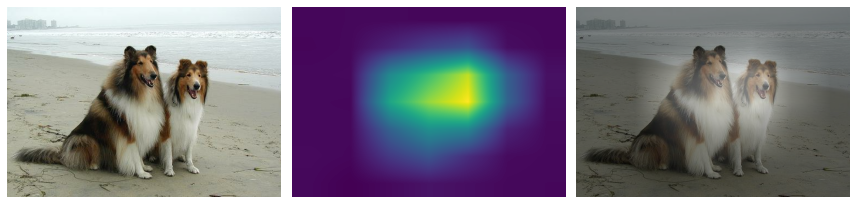

In [30]:
cam_image_1 = generate_cam(cam_model, item)  # CAM 이미지 얻기
blended_image_1 = visualize_cam_on_image(item, cam_image_1)  # CAM 이미지와 원본 이미지 합치기

draw_imgs(item, cam_image_1, blended_image_1, filename='CAM_Iamge_1.png')

#Grad-CAM 구현하기
1. 이번 노드에 나왔던 Grad-CAM을 직접 구현해 봅시다. 예제 코드를 최대한 보지 말고, 설명과 이론을 보고 구현해 보세요.

80


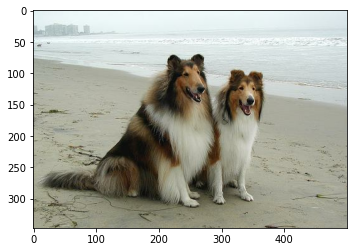

In [31]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

In [32]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # output의 k번째 채널과 k번째 weight를 곱하고 누적해서 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image = tf.math.maximum(0, grad_cam_image)
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

2. 만든 함수로 여러 레이어의 CAM 이미지를 뽑아서 직접 확인해 보세요.

3. 위에서 만든 이미지 visualize_cam_on_image() 함수로 이미지를 시각화해 보세요.

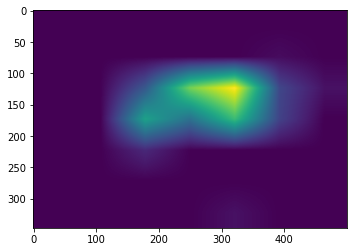

In [33]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

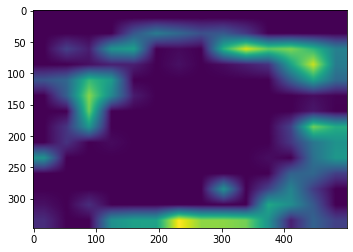

In [34]:
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

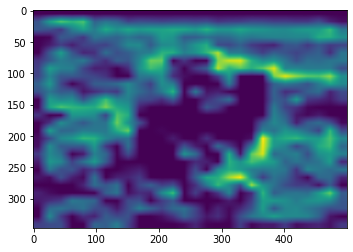

In [35]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

# 바운딩 박스 구하기

1. 제시된 코드를 참고해, 직접 Grad-CAM으로 얻은 CAM을 통해서 바운딩 박스를 얻어보세요.

2. 1)에서 얻은 바운딩 박스를 시각화해 보세요.

67


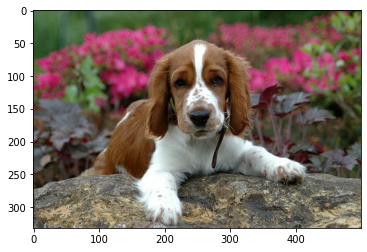

In [36]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

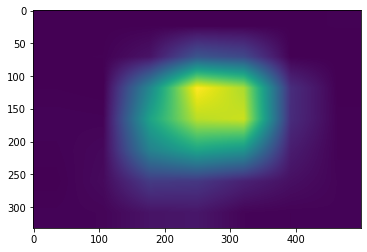

In [37]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

In [38]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

In [39]:
rect = get_bbox(cam_image)
rect

array([[113,  33],
       [435,  33],
       [435, 331],
       [113, 331]])

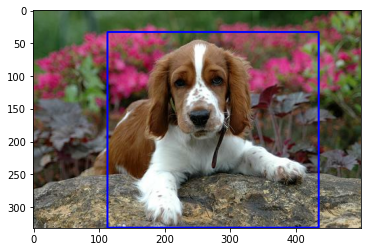

In [40]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

In [41]:
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어집니다. 
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

minmax bbox형태로 치환

In [42]:
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[0.09939759036144578, 0.226, 0.9969879518072289, 0.87]

ground truth 확인

In [43]:
item['objects']['bbox']

array([[0.13554217, 0.146     , 0.9879518 , 0.826     ]], dtype=float32)

#IoU 구하기
1. 정답 바운딩 박스(ground truth) 와 예측값 바운딩 박스(prediction box) 두 가지를 이용해서 IoU를 계산하는 get_iou() 함수를 만들어 주세요.

In [44]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

2. CAM과 Grad-CAM으로 얻은 바운딩 박스와 정답 바운딩 박스와의 IoU를 각각 비교해 봅시다.



In [45]:
get_iou(pred_bbox, item['objects']['bbox'][0])

0.7914165279902834

#결론
이번 프로젝트에서는 CAM, GradCAM을 직접 구현해보고 평가를 해보는 시간을 가졌습니다.

CAM을 이용하여 어디를 보고 이미지를 출력하는지 보았을 때 강아지의 전반적인 영역에서 골고루 탐지하는 것을 알 수 있었습니다. 

IoU를 이용하여 CAM으로 추출해낸 바운딩 박스와 정답 바운딩 박스를 비교하여, 찾고자 하는 물건의 절대적인 면적과 상관없이, 영역을 정확하게 잘 찾아내었는지의 상대적인 비율을 구할 수 있었고, 모델이 영역을 잘 찾았는지 비교해보았습니다.

# 회고

---



## - 이번 프로젝트에서 어려웠던 점

직접 LMS에서 보았던 CAM이나 IoU함수를 구현하는 것이 쉽지 않았습니다.

그리고 특정 에포크 수 이상 진행하면서 accuracy가 1이 나와 오버피팅이 되어 그 현상에 대한 분석이 어려웠습니다. 

---


## - 프로젝트를 진행하면서 알게된 점
레이어에서 직접 사용해야할 최종 특징맵이 어느 곳의 출력 값인지 알게 되었습니다.


---


## - 루브릭 평가지표를 맞추기 위해 시도한 것들

기본적인 모델을 ResNet50 + GAP + DenseLayer 구현해보았고, 

CAM의 class activation map이 정상적으로 시각화 되었으며 특정위치를 잘 반영하도록 했습니다.

---


## - 자기다짐
전반적인 모델의 흐름과 전체적인 이해를 먼저 높이는게 중요하다고 생각해서 논문을 시간을 두고 지긋이 보는 습관이 필요하다고 느꼈습니다.
